In [16]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json
from PIL import Image, ImageChops, ImageEnhance
import PIL
import os
import itertools
from tqdm import tqdm
tf.__version__

'2.4.1'

In [17]:
def ELA(img_path, quality=90):
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    diff=""
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d=diff.load()
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
#     save_path = dataset_path +'ELA_IMAGES/'
#     diff.save(save_path+'diff.png')
    return diff

In [18]:
dataset_path="../input/casia-20-image-tampering-detection-dataset/CASIA2/"
path_original = 'Au/'
path_tampered = 'Tp/'
# path_mask='CASIA 2 Groundtruth/'
total_original = os.listdir(dataset_path+path_original)
total_tampered = os.listdir(dataset_path+path_tampered)
# total_mask=os.listdir(dataset_path+path_mask)


In [19]:
pristine_images = []
for i in total_original:
    pristine_images.append(dataset_path+path_original+i)
fake_images = []
for i in total_tampered:
    fake_images.append(dataset_path+path_tampered+i)

In [20]:
len(total_tampered),len(fake_images)

(5125, 5125)

In [21]:
image_size = (224,224)
output_path='./'

In [22]:
# os.rmdir(output_path+"resized_images/fake_images/")
# os.rmdir(output_path+"resized_images/pristine_images/")
# os.rmdir(output_path+"resized_images/")

In [23]:
output_path='./'
if not os.path.exists(output_path+"resized_images/"):
#     os.makedirs(output_path+"resized_images/fake_masks/")
    os.makedirs(output_path+"resized_images/fake_images/")
    os.makedirs(output_path+"resized_images/pristine_images/")
    height = 224
    width = 224
#     p2=output_path+"resized_images/fake_masks/"
    p1=output_path+"resized_images/fake_images/"
    p3=output_path+"resized_images/pristine_images/"
    j=0
    for fake_image in tqdm(total_tampered):
        try:
            img=Image.open(dataset_path+path_tampered + fake_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p1+fake_image)
            j+=1
        except:
            print("Encountered Invalid File : ",fake_image)
        if(j==1000):
            break
    j=0
    for pristine_image in tqdm(total_original):
        try:
            img=Image.open(dataset_path+path_original + pristine_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p3+pristine_image)
            j+=1
        except:
            print("Invalid File : " ,pristine_image)
        if(j==1000):
            break
        
        
else:
    print('images resized,path exists')

images resized,path exists


In [24]:
resized_fake_image_path=output_path+"resized_images/fake_images/"
resized_pristine_image_path=output_path+"resized_images/pristine_images/"
resized_fake_image=os.listdir(resized_fake_image_path)
resized_pristine_image=os.listdir(resized_pristine_image_path)

In [25]:
# os.rmdir(ela_real)
# os.rmdir(ela_fake)
# os.rmdir('ELA_IMAGES/')

In [26]:
ela_images_path=output_path+'ELA_IMAGES/'
ela_real=ela_images_path+'Au/'
ela_fake=ela_images_path+'Tp/'
if not os.path.exists(ela_images_path):
    os.makedirs(ela_images_path)
    os.mkdir(ela_real)
    os.mkdir(ela_fake)
    for i in tqdm(resized_fake_image):
        ELA(resized_fake_image_path+i).save(ela_fake+i)
    for i in tqdm(resized_pristine_image):
        ELA(resized_pristine_image_path+i).save(ela_real+i)
else:
    print('Images are already converted to ELA')

Images are already converted to ELA


In [82]:
X=[]
Y=[]
j=0
for file in tqdm(os.listdir(ela_real)):
    img=Image.open(ela_real+file)
    img=np.array(img)
    X.append(img)
    Y.append(0)
    j+=1
    if(j==1000):
        break
j=0
for file in tqdm(os.listdir(ela_fake)):
    img=Image.open(ela_fake+file)
    img=np.array(img)
    X.append(img)
    Y.append(1)
    j+=1
    if(j==1000):
        break

 50%|████▉     | 999/2000 [00:00<00:00, 1308.48it/s]


In [83]:
X=np.array(X)
X.shape
X=5*X

In [84]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2, random_state=133,shuffle=True)
y_train=to_categorical(y_train,2)
y_dev=to_categorical(y_dev,2)

In [91]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization,Dropout

base_model=MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(128,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(64,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(16,activation='relu')(x)
x=Dense(2,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=x)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# model.summary()
# base=MobileNetV2()

In [92]:
epochs = 100
batch_size = 16

In [93]:
import keras
# if not os.path.exists('./model_checkpoints'):
#     os.makedirs('./model_checkpoints')
# # define callbacks for learning rate scheduling and best checkpoints saving
# filepath = './model_checkpoints/image_tampering_classification_ela.h5'
# checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='val_accuracy',save_best_only=True,verbose=1)

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=13,verbose=1,restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.22, patience = 6, verbose = 1, 
                                              min_delta = 0.0001,min_lr=0.0001)

In [94]:
hist = model.fit(x_train,y_train,
                 epochs = epochs,
                validation_data = (x_dev,y_dev),
                callbacks = [early_stop,reduce_lr],
                verbose=1,shuffle=True)

Epoch 1/100
50/50 [==============================] - 14s 181ms/step - loss: 0.6758 - accuracy: 0.6357 - val_loss: 0.6685 - val_accuracy: 0.5150
Epoch 2/100
50/50 [==============================] - 8s 163ms/step - loss: 0.5153 - accuracy: 0.7317 - val_loss: 0.7939 - val_accuracy: 0.4850
Epoch 3/100
50/50 [==============================] - 8s 167ms/step - loss: 0.5264 - accuracy: 0.7353 - val_loss: 0.5087 - val_accuracy: 0.7775
Epoch 4/100
50/50 [==============================] - 8s 159ms/step - loss: 0.4381 - accuracy: 0.7697 - val_loss: 0.6981 - val_accuracy: 0.4825
Epoch 5/100
50/50 [==============================] - 8s 164ms/step - loss: 0.4379 - accuracy: 0.7834 - val_loss: 0.6571 - val_accuracy: 0.7200
Epoch 6/100
50/50 [==============================] - 8s 164ms/step - loss: 0.3984 - accuracy: 0.8126 - val_loss: 0.5412 - val_accuracy: 0.7950
Epoch 7/100
50/50 [==============================] - 8s 166ms/step - loss: 0.3495 - accuracy: 0.8412 - val_loss: 1.2482 - val_accuracy: 0.500

In [ ]:
# model.save('/kaggle/working/model_casia_run1.h5')
# model.save_weights('/kaggle/working/model_casia_run1.h5')

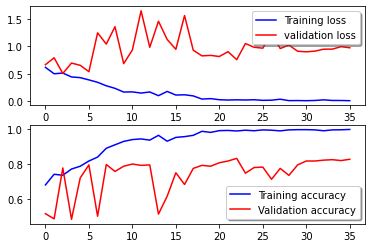

In [95]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [96]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    


In [97]:
pred=model.predict(x_dev)

In [98]:
pred[0:20]

array([[9.93835330e-01, 6.16474869e-03],
       [5.49220658e-06, 9.99994516e-01],
       [8.52094233e-01, 1.47905752e-01],
       [1.48671325e-02, 9.85132813e-01],
       [9.94102061e-01, 5.89790335e-03],
       [8.10866368e-06, 9.99991894e-01],
       [8.56872816e-07, 9.99999166e-01],
       [9.92889643e-01, 7.11038569e-03],
       [9.86617744e-01, 1.33822877e-02],
       [4.51793812e-06, 9.99995470e-01],
       [1.99279020e-06, 9.99997973e-01],
       [9.88451242e-01, 1.15487110e-02],
       [8.82917491e-04, 9.99117076e-01],
       [9.96644735e-01, 3.35531053e-03],
       [6.59659918e-07, 9.99999285e-01],
       [2.07443009e-06, 9.99997973e-01],
       [9.96940017e-01, 3.06005334e-03],
       [9.97176051e-01, 2.82389997e-03],
       [9.94793475e-01, 5.20651229e-03],
       [9.98405993e-01, 1.59397360e-03]], dtype=float32)

In [99]:
print("Loss of the model is - " , model.evaluate(x_dev,y_dev)[0])
print("Accuracy of the model is - " , model.evaluate(x_dev,y_dev)[1]*100 , "%")

13/13 [==============================] - 0s 24ms/step - loss: 0.7601 - accuracy: 0.8325
Loss of the model is -  0.7601341009140015
13/13 [==============================] - 0s 25ms/step - loss: 0.7601 - accuracy: 0.8325
Accuracy of the model is -  83.24999809265137 %


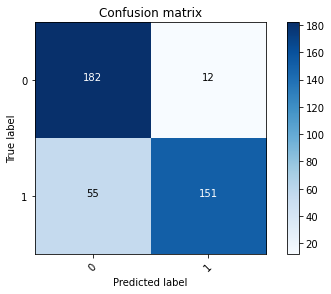

In [100]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_dev)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_dev,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

Prediction

In [101]:
class_names = ['real','fake']

In [102]:
real_image_path = '../input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg'
image = ELA(real_image_path)
image=image.resize((224, 224), PIL.Image.ANTIALIAS)
image=np.array(image)
image = image.reshape(-1, 224, 224, 3)
# image=np.array(image)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')


Class: real Confidence: 77.94


In [103]:
fake_image_path = '../input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00022.jpg'
image = ELA(fake_image_path)
image=image.resize((224, 224), PIL.Image.ANTIALIAS)
image=np.array(image)
image = image.reshape(-1, 224, 224, 3)
# image=np.array(image)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 98.57


In [104]:
for i in range(len(x_dev)):
    image=x_dev[i]
    image=np.array(image)
    image = image.reshape(-1, 224, 224, 3)
    y_true=0
    if(y_dev[i][1]==1):
        y_true=1
    y_pred = model.predict(image)
    y_pred_class = np.argmax(y_pred, axis = 1)[0]
    total += 1
    
    if y_pred_class == y_true:
            correct += 1        
    print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')
    print(f'Class: {class_names[y_true]}')
    print('******************')

Class: real Confidence: 99.38
Class: real
******************
Class: fake Confidence: 100.00
Class: fake
******************
Class: real Confidence: 85.21
Class: fake
******************
Class: fake Confidence: 98.51
Class: real
******************
Class: real Confidence: 99.41
Class: real
******************
Class: fake Confidence: 100.00
Class: fake
******************
Class: fake Confidence: 100.00
Class: fake
******************
Class: real Confidence: 99.29
Class: fake
******************
Class: real Confidence: 98.66
Class: real
******************
Class: fake Confidence: 100.00
Class: fake
******************
Class: fake Confidence: 100.00
Class: fake
******************
Class: real Confidence: 98.85
Class: real
******************
Class: fake Confidence: 99.91
Class: fake
******************
Class: real Confidence: 99.66
Class: real
******************
Class: fake Confidence: 100.00
Class: fake
******************
Class: fake Confidence: 100.00
Class: fake
******************
Class: real Confi

In [105]:
# fake_image = os.listdir('../input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/')
# correct = 0
# total = 0
# for file_name in fake_image:
#     if file_name.endswith('jpg') or file_name.endswith('png'):
#         fake_image_path = os.path.join('../input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/', file_name)
# #         image = prepare_image(fake_image_path)
#         image = ELA(fake_image_path)
#         image=image.resize((224, 224), PIL.Image.ANTIALIAS)
#         image=np.array(image)
#         image = image.reshape(-1, 224, 224, 3)
#         y_pred = model.predict(image)
#         y_pred_class = np.argmax(y_pred, axis = 1)[0]
#         total += 1
#         if y_pred_class == 1:
#             correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [106]:
# print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

In [107]:
# real_image = os.listdir('../input/casia-20-image-tampering-detection-dataset/CASIA2/Au/')
# correct_r = 0
# total_r = 0
# for file_name in real_image:
#     if file_name.endswith('jpg') or file_name.endswith('png'):
#         real_image_path = os.path.join('../input/casia-20-image-tampering-detection-dataset/CASIA2/Au/', file_name)
#         image = ELA(real_image_path)
#         image=image.resize((224, 224), PIL.Image.ANTIALIAS)
#         image=np.array(image)
#         image = image.reshape(-1, 224, 224, 3)
#         y_pred = model.predict(image)
#         y_pred_class = np.argmax(y_pred, axis = 1)[0]
#         total_r += 1
#         if y_pred_class == 0:
#             correct_r += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [108]:
# correct += correct_r
# total += total_r
# print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
# print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

In [ ]:
# model.save('/kaggle/working/model_casia_run2.h5')
# model.save_weights('/kaggle/working/model_casia_run1.h5')

In [109]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/kaggle/working/model_casia_run.h5")
print("Saved model to disk")

Saved model to disk
